In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = [6,6]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

### Data retrieval

In [4]:
import os, requests
fname = "data.zip"
url = "https://osf.io/rc3zw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/steinmetz_single_session.npy  
  inflating: __MACOSX/data/._steinmetz_single_session.npy  
  inflating: data/hcp_motor_task_fMRI.npy  
  inflating: __MACOSX/data/._hcp_motor_task_fMRI.npy  
  inflating: data/steinmetz_spike_times.npy  
  inflating: __MACOSX/data/._steinmetz_spike_times.npy  


In [5]:
spike_times = np.load('data/steinmetz_spike_times.npy', allow_pickle = True)

_A single recording session of spike times and neuron assignments (734 neurons) was loaded and assigned to spike_times in the preceding setup_

# Section 1: Learning about different visualization techniques (histogram, density plot, line plot) using the Steinmetz dataset

In the first part of this data visualization lesson, we will explore the structure of a neuroscience dataset.

We consider a subset of data from a study of [Steinmetz _et al._ (2019)](https://www.nature.com/articles/s41586-019-1787-x). In this study, Neuropixels probes were implanted in the brains of mice. Electrical potentials were measured by hundreds of electrodes along the length of each probe. Each electrode's measurements captured local variations in the electric field due to nearby spiking neurons. A spike sorting algorithm was used to infer spike times and cluster spikes according to common origin: a single cluster of sorted spikes is causally attributed to a single neuron.

In particular, a single recording session of spike times and neuron assignments was loaded and assigned to `spike_times` in the preceding setup.

Typically a dataset comes with some information about its structure. However, this information may be incomplete. You might also apply some transformations or "pre-processing" to create a working representation of the data of interest, which might go partly undocumented depending on the circumstances. In any case it is important to be able to use the available tools to investigate unfamiliar aspects of a data structure.

Let's see what our data looks like...

## Warming up with `spike_times`

What is the Python type of our variable?
```python
type(spike_times)
```

In [6]:
type(spike_times)

numpy.ndarray

You should see `numpy.ndarray`, which means that it's a normal NumPy array.

If you see an error message, it probably means that you did not execute the set-up cells at the top of the notebook. So go ahead and make sure to do that.

Once everything is running properly, we can ask the next question about the dataset: what's its shape?
```python
spike_times.shape
```

In [7]:
spike_times.shape

(734,)

There are 734 entries in one dimension, and no other dimensions. What is the Python type of the first entry, and what is *its* shape?
```python 
idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)
```

In [8]:
idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(826,)


It's also a NumPy array with a 1D shape! Why didn't this show up as a second dimension in the shape of `spike_times`? That is, why not `spike_times.shape == (734, 826)`?

To investigate, let's check another entry.
```python
idx = 321
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)
```

In [9]:
idx = 321
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(9723,)


It's also a 1D NumPy array, but it has a different shape. Checking the NumPy types of the values in these arrays, and their first few elements, we see they are composed of floating point numbers (not another level of `np.ndarray`):
```python
i_neurons = [0, 321]
i_print = slice(0, 5)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    spike_times[i].dtype,
    spike_times[i][i_print],
    "\n",
    sep="\n"
  )
  ```

In [10]:
i_neurons = [0, 321]
i_print = slice(0, 5)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    spike_times[i].dtype,
    spike_times[i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




Note that this time we've checked the NumPy `dtype` rather than the Python variable type. These two arrays contain floating point numbers ("floats") with 32 bits of precision.

The basic picture is coming together:
- `spike_times` is 1D, its entries are NumPy arrays, and its length is the number of neurons (734): by indexing it, we select a subset of neurons.
- An array in `spike_times` is also 1D and corresponds to a single neuron; its entries are floating point numbers, and its length is the number of spikes attributed to that neuron. By indexing it, we select a subset of spike times for that neuron.

Visually, you can think of the data structure as looking something like this:

```
| . . . . . |
| . . . . . . . . |
| . . . |
| . . . . . . . |
```

Before moving on, we'll calculate and store the number of neurons in the dataset and the number of spikes per neuron:
```python
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")
```

In [11]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


## Getting warmer: counting and plotting total spike counts

As we've seen, the number of spikes over the entire recording is variable between neurons. More generally, some neurons tend to spike more than others in a given period. Let's explore what the distribution of spiking looks like across all the neurons in the dataset.

Are most neurons "loud" or "quiet", compared to the average? To see, we'll define bins of constant width in terms of total spikes and count the neurons that fall in each bin. This is known as a "histogram".

## Visualization Type 1: Histogram
* Histograms are used to provide information about a single set of numbers 

* It is used to display the frequency of data points within specific intervals, which are also known as bins

* It consists of different bars, where the height of each bar indicates how many data points fall within that specific range of values, so within each bin

* They are particularly useful for visualizing the range of values of a variable and the shape of the distribution

You can plot a histogram with the matplotlib function `plt.hist`. If you just need to compute it, you can use the numpy function `np.histogram` instead.
```python
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");
```

Text(0, 0.5, 'Number of neurons')

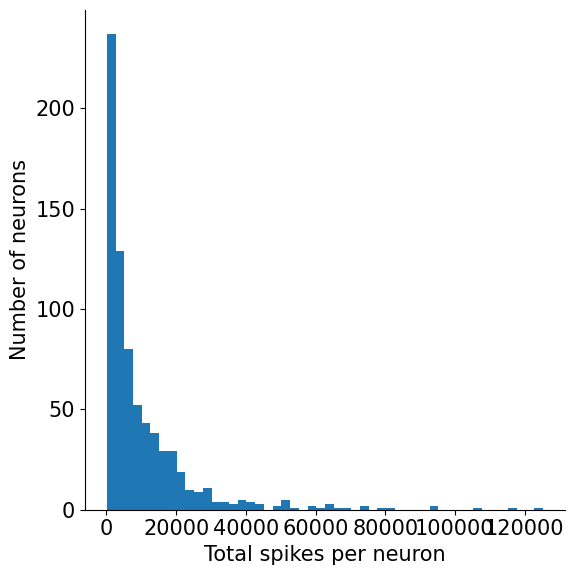

In [12]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")

Now try adding the average spike count to the histogram plot

Text(0, 0.5, 'Number of neurons')

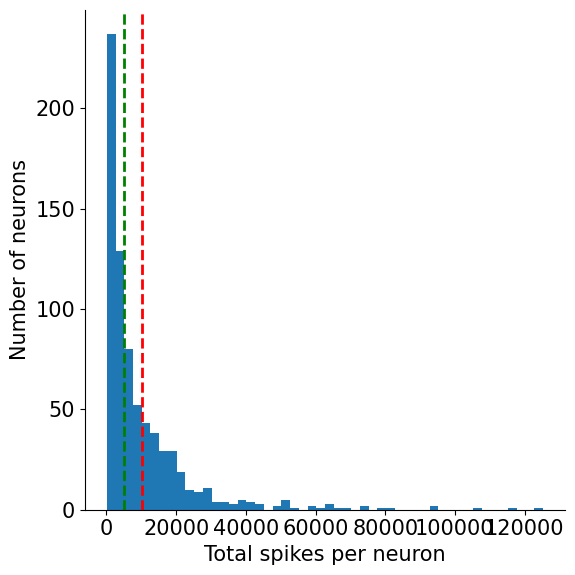

In [17]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.axvline(np.mean(total_spikes_per_neuron), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.median(total_spikes_per_neuron), color='green', linestyle='dashed', linewidth=2)

plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")

## Visualization Type 2: Density Plot 

Another similar plot that we could use to visualize the distribution of a dataset is the density plot. 
So in the histogram, we binned the values within a certain range, so we created these intervals and then we computed the number of data points that lie within each interval. 
In the density plot, we calculate a smooth approximation to the data distribution without predefining any bins

* In density plots, instead of the frequency, you can interpret the y-axis as reflecting the probability of variables values falling within a small interval around that point
* Density plots can also be helpful to identify extreme values

```python 
import seaborn as sns
sns.distplot(total_spikes_per_neuron, hist=False)
```

<Axes: ylabel='Density'>

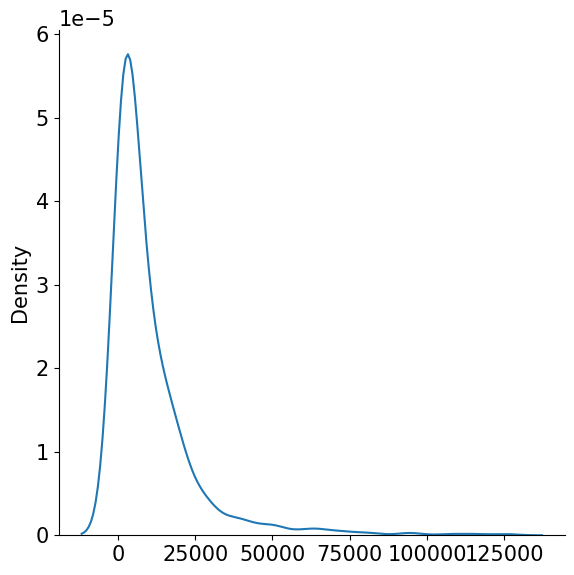

In [20]:
sns.kdeplot(total_spikes_per_neuron)

### Bonus: Can you think of other variables whose distributions could be interesting to explore with single-neuron data?

We know that there are physical constraints on neuron spiking. Spiking costs energy, which the neuron's cellular machinery can only obtain at a finite rate. Therefore neurons should have a refractory period: they can only fire as quickly as their metabolic processes can support, and there is a minimum delay between consecutive spikes of the same neuron.

More generally, we can ask "how long does a neuron wait to spike again?" or "what is the longest a neuron will wait?" Can we transform spike times into something else, to address questions like these more directly?

We can consider the inter-spike times (or interspike intervals: ISIs). These are simply the time differences between consecutive spikes of the same neuron.

#### Exercise: Plot the distribution of ISIs for a single neuron

*Exercise objective:* make a histogram, like we did for spike counts, to show the distribution of ISIs for one of the neurons in the dataset.

Do this in three steps:

1. Extract the spike times for one of the neurons (say neuron at index 283)
2. Compute the ISIs (the amount of time between spikes, or equivalently, the difference between adjacent spike times)
3. Plot a histogram with the array of individual ISIs


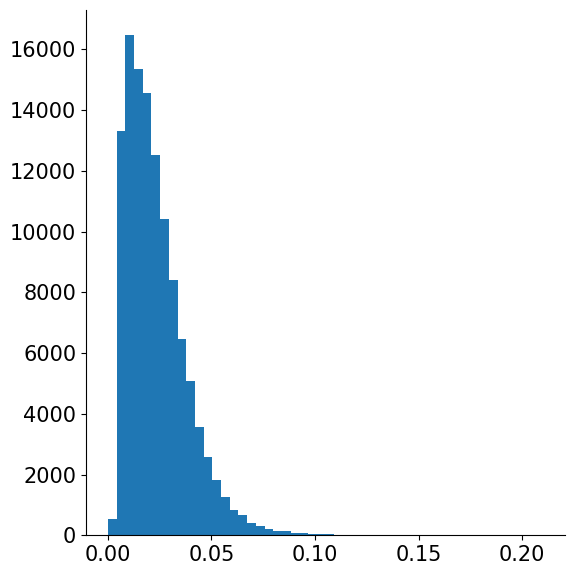

In [23]:
isi = np.diff(spike_times[283])
plt.hist(isi, bins=50, histtype="stepfilled");

## Visualization Type 3: Spike trains and raster plots 

Now we'll visualize trains of spikes. Because the recordings are long, we will first define a short time interval and restrict the visualization to only the spikes in this interval. We defined a helper function, `restrict_spike_times`, to do this for you. 

In [24]:
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

```python 
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)
```

In [25]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

Now that we have a smaller subset, we're ready to plot the spikes, using the matplotlib `plt.eventplot` function. Let's look at a single neuron first:
```python
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);
```

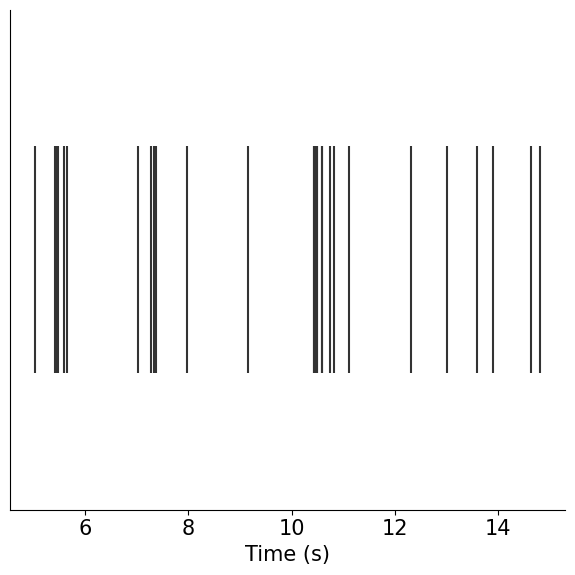

In [26]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

We can also plot multiple neurons. Here are three:
```python
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);
```

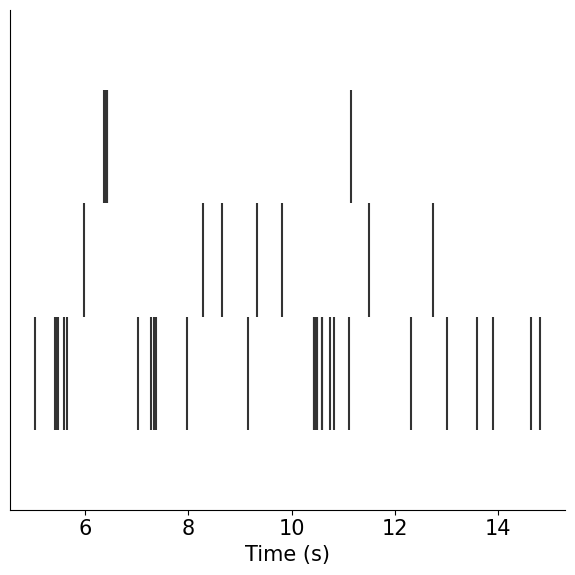

In [27]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

This makes a "raster" plot, where the spikes from each neuron appear in a different row.

Plotting a large number of neurons can give you a sense for the characteristics in the population. Let's show every 5th neuron that was recorded:

```python 
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);
```

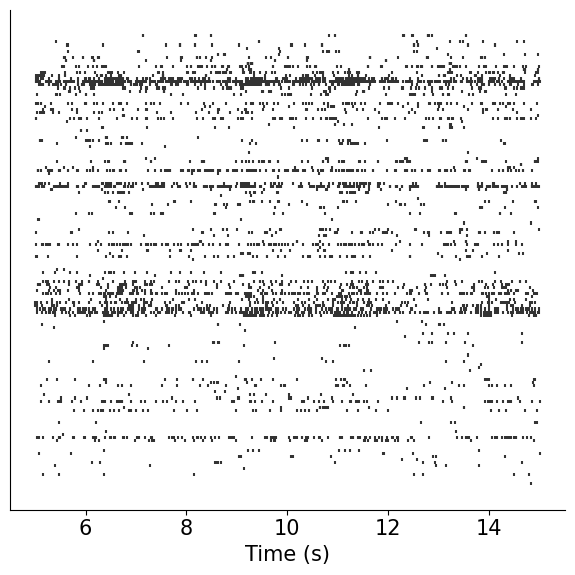

In [28]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

*Question*: How does the information in this plot relate to the histogram of total spike counts that you saw above?

## Visualization Type 4: Line plot

* Display data points along a continouous line 
* Most commonly, used to visualize trends over time
  


We'll again work with the Neuropixels data as described above, except here the data is organized according to time bins for ease of visualization 

   
```python 
dat = np.load('data/steinmetz_single_session.npy', allow_pickle = True).item()
```

* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['bin_size']`: Bin size in s.
* `dat['time_onset']`: time of the stimulus onset. 


In [29]:
dat = np.load('data/steinmetz_single_session.npy', allow_pickle = True).item()


We can first do a basic line plot of population average
```python 
dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'].mean(axis=(0, 1)))
plt.xlabel('time (sec)') 


Text(0, 0.5, 'firing rate (Hz)')

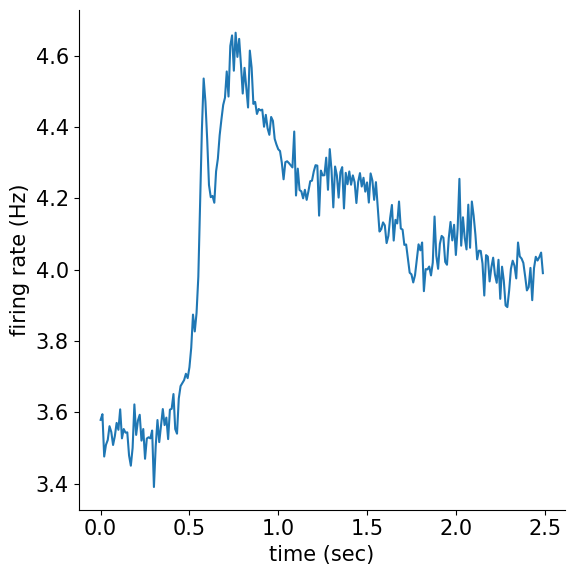

In [30]:
dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'].mean(axis=(0, 1)))
plt.xlabel('time (sec)') 
plt.ylabel('firing rate (Hz)')

* If you’re plotting two sets of values at the same time, this would become a two series lineplot 
* If you have multiple sets of values, that would be a multiple series lineplot.

In this example, we might want to visualize the average firing rates across neurons in different brain regions separately. 

Let's group different brain areas into broader brain regions
```python
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]
```

Now we can plot the average firing rates for different brain areas separately

In [32]:
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]


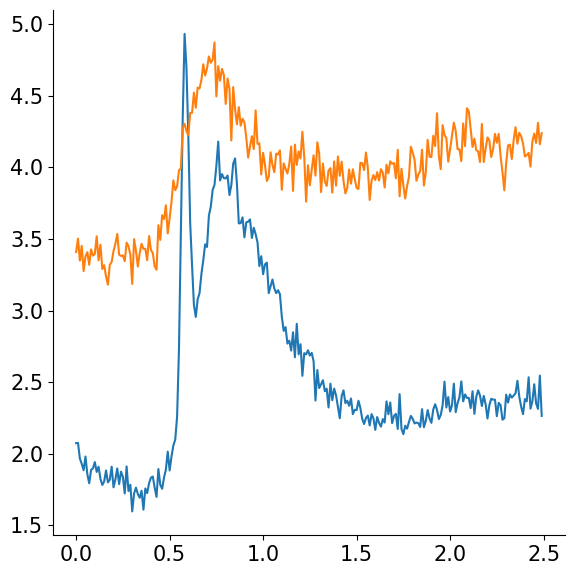

In [33]:

dat['spks']
mask1 = np.isin(dat['brain_area'], brain_groups[0])
mask2 = np.isin(dat['brain_area'], brain_groups[2])
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][mask1].mean(axis=(0, 1)), label='visual')
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][mask2].mean(axis=(0, 1)), label='hippocampal')

When you are using a lineplot, you should make sure that the categories you have on the x axes are not independent. You cannot use a lineplot to display trends over arbitrary categories that are unordered. Lets say your categories were different neurons on the x-axis, in this case a lineplot would not make sense because these categories are all unordered. 

# Section 2: Learning about other visualization techniques (scatter plot, barplot, boxplot) using the HCP task-fMRI dataset 

The HCP dataset comprises task-based fMRI from a large sample of human subjects. We will use the NMA-curated version of the dataset that includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).


```python
data = np.load('data/hcp_motor_task_fMRI.npy', allow_pickle = True).item()
```

This task was adapted from the one developed by Buckner and colleagues (Buckner et al.
2011; Yeo et al. 2011). 

Participants are presented with visual cues that ask them to either tap
their left or right fingers, or squeeze their left or right toes, or move their tongue to map motor
areas. Each block of a movement type lasted 12 seconds (10 movements), and is preceded by
a 3 second cue. In each of the two runs, there are 13 blocks, with 2 of tongue movements, 4 of
hand movements (2 right and 2 left), and 4 of foot movements (2 right and 2 left). In addition,
there are 3 15-second fixation blocks per run. This task contains the following events, each of
which is computed against the fixation baseline.

## Warming up with `data`

What is the Python type of our variable?
```python
type(data)
```

Let's look at the keys in our dictionary 

What is the shape of the brain data? 

As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).

Now let's look at `region_info` 

`region_info` contains the region name and network assignment as well as the hemisphere for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/)

Now in order to understand the brain activity data, we need to relate the time series to the experimental manipulation. This is described in `task_info`. 


Let's take a look!

For the motor task, this dictionary contains a list of arrays corresponding to each of the conditions in the experiment: 
* 'lf': Left foot
* 'rf': Right foot
* 'lh': Left hand
* 'rh': Right hand
* 't': Tongue 
* 'cue'

The basic picture is coming together:
- `brain_data` stores the activity in a NumPy array, its entries are NumPy arrays, and its length is the number of brain regions (360): by indexing it, we select a subset of regions.
- `region_info` is a dictionary that provides information about each region of interest 
- `task_info` is a dictionary that provides information that can be used to relate brain activity data to experimental manipulations

Now that we understand the data, let's start to look at a few other visualization techniques! 

## Visualization Type 5: Scatter plot
Scatterplot visualizes two continuous variables against one another

As an example, let's say you are interested in visualizating the relationship between two numeric variables: 
brain activity in left hemisphere V1 and right hemisphere V1. 

You can do that using a scatter plot by explicitly calling pyplot's scatter() function
```python
plt.scatter()
```

## Visualization Type 5: Bar plot

A barplot is used to compare the values for different categories or groups.

Each bar typically represents a category, and the height or length of the bar corresponds to the frequency, proportion, or some other measure associated with that category.

As an example, let's visualize the mean activity within the left and right somatomotor regions for the left foot condition

#### Exercise: 
Extract the mean activity within the left and right somatomotor regions for the left foot condition and store it in two variables `data_l` and `data_r' respectively. 
And then use the following code to compare values across groups using barplot

```python
f, ax = plt.subplots(figsize = (5,5))
plt.bar(['Left', 'Right'], [data_l.mean(), data_r.mean()])
plt.ylabel('Mean fMRI response')
```

We can also add error bars to this bar plot

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn to visualise it 
```python
import seaborn as sns
import pandas as pd
df = pd.DataFrame({'activity' : [data_l.mean(), data_r.mean()],
                   'hemi' : ['left', 'right']})

f, ax = plt.subplots(figsize = (5, 5))
sns.barplot(x='hemi', y ='activity', data=df, hue='hemi')

```

You can also store individual valuues for each data point rather than taking the mean across all timepoints. This can allow you to plot errorbars as well. 

```python 
df = pd.DataFrame({'activity' : np.concatenate([data_l, data_r]),
                   'hemi' : ['left']* len(data_l) + ['right']*len(data_r)})

f, ax = plt.subplots(figsize = (5, 5))
sns.barplot(x='hemi', y ='activity', data=df, hue='hemi')
```

## Visualization Type 5.1: Grouped barplots 
Grouped bar plots are a type of bar graph that display multiple bars for each category or group, with each group consisting of bars representing different subcategories or conditions

#### Exercise: 
Plot a grouped bar chart showing the mean activity across the left and right somatomotor network for the two experimental conditions (left foot and right foot movements) respectively
Here, each experimental manipulation reflects a 'group'. 


Do this in three steps:

1. Create a pandas dataframe with 3 columns for `experiment`, `hemi`, `activity` respectively 
2. Store the mean activity within each network (left and right somatomor regions) for each experimental condition (lf and rf) in the dataframe
3. Using seaborn, generate a barplot from this dataframe


## Visualization Type 6: Box plot

Box plots like bar charts in that they are also used to depict the summary of numerical or continuous variables across categories but they have this additional feature that they can also be used to visualize the variation in the values around the median.


As an example, let's visualize the data from the 'rf' experiment condition above using a boxplot 
```python
f, ax = plt.subplots(figsize = (5,5))
sns.boxplot(x='hemi', y ='activity', data=df[df['experiment'] == 'rf'])
```

Here is how to read a boxplot. 
* The line in the middle of the boxplot represent the median values of the variable for each category. 
* If you use libraries for making boxplot, they often also have the additional option for showing means in addition to medians in boxplots
* The top and bottom values give you the typical range of values (max and min) for each category, excluding certain outliers. 
* Box lines indicate the first (lower) quartile and third (upper) quartile